# **Problem set 5** - Machine Learning for Physics and Astronomy 2023/2024, UvA

- The total sheet gives 22 points
- Deadline for submitting your results is **Wed, 23/5/2024, 23:59**
- **IMPORTANT**: Specify if/how AI was used to solve the exercises by filling the corresponding "Usage of AI" comments. Anything between "No" (if applicable) and a short paragraph reflecting how AI was used is fine. Failing to do so faithfully will result in the substraction of points.
- **IMPORTANT**: this sheet is to be updated to also cover the material from lectures 10 and 11.

### Remember, if you get the error "No CUDA GPUs are available," go to Runtime > Change runtime type > select GPU.

## Chapter 10: Simulation based inference (22 pt)

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

### 1. Measuring Rings (7 pt)

In the last homework session we classified numbers on the MNIST dataset, but this is not representative of the types of tasks that we use neural neutworks for in physics. So we now move on to a different task: measuring the radius of rings produced by a simulator. We define a function that serves as our "simulator," `image_model` which produces images with one or more rings, where the radius, width, and number of rings are simulation parameters.

This model is a toy model for producing simulated images of graviationally lensed systems.  The radius would then correspond to the "Einstein radius" of the [gravitational lensing system](https://en.wikipedia.org/wiki/Einstein_ring) and tell us something about the mass of the lensing galaxy. The width would correspond to the size of the lensed source galaxy.  Normally, you would not get multiple rings in one image, but in our toy model we add this possibility to test just how difficult we can make the problem while still learning the parameters.

As an example, a real strong lensing image looks like this:

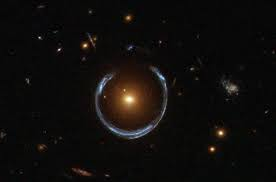

So now we define our "simulator."

In [2]:
def image_model(radius = 0.5, sigma = 0.3, width = 0.15, n = 1):
    x = np.linspace(-2, 2, 32)
    X, Y = np.meshgrid(x, x)

    # Random position of the ring
    imgs = []
    for i in range(n):
      x0, y0 = np.random.uniform(-1, 1, 2)

      R = ((X-x0)**2 + (Y-y0)**2)**0.5
      img = np.exp(-(R-radius)**2/width**2/2)
      img = img

      imgs.append(img)

    # Standard variance and zero mean
    img = sum(imgs)

    # Remove mean and variance
    img -= img.mean()
    img /= img.std()

    # Add image noise
    img += np.random.randn(*img.shape)*sigma


    return img.reshape(1, 32, 32).astype(np.float32)  # Default CUDA tensors are float32

Next, we next generate our training and test data. In this case, 50000 examples.

In [3]:
ring_data = []
for i in range(50000):
  r = np.random.rand(1).astype(np.float32)
  img = image_model(n = 3, radius = r)
  ring_data.append((img, r))

class RingDataset(torch.utils.data.Dataset):
  def __init__(self, ring_data):
    self.ring_data = ring_data

  def __getitem__(self, idx):
    return self.ring_data[idx]

  def __len__(self):
    return len(self.ring_data)

ring_dataset_train = RingDataset(ring_data[:45000])
ring_dataset_test = RingDataset(ring_data[45000:])

We then instantiate the loaders.

In [4]:
batch_size_train = 64  # by default we use a minibatch size of 64 for training.
# You can leave it like that during the subsequent exercises.

batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(ring_dataset_train, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ring_dataset_test, batch_size=batch_size_test, shuffle=True)

In [5]:
examples = list(test_loader)
example_data, example_targets = examples[0]

And plot test examples.

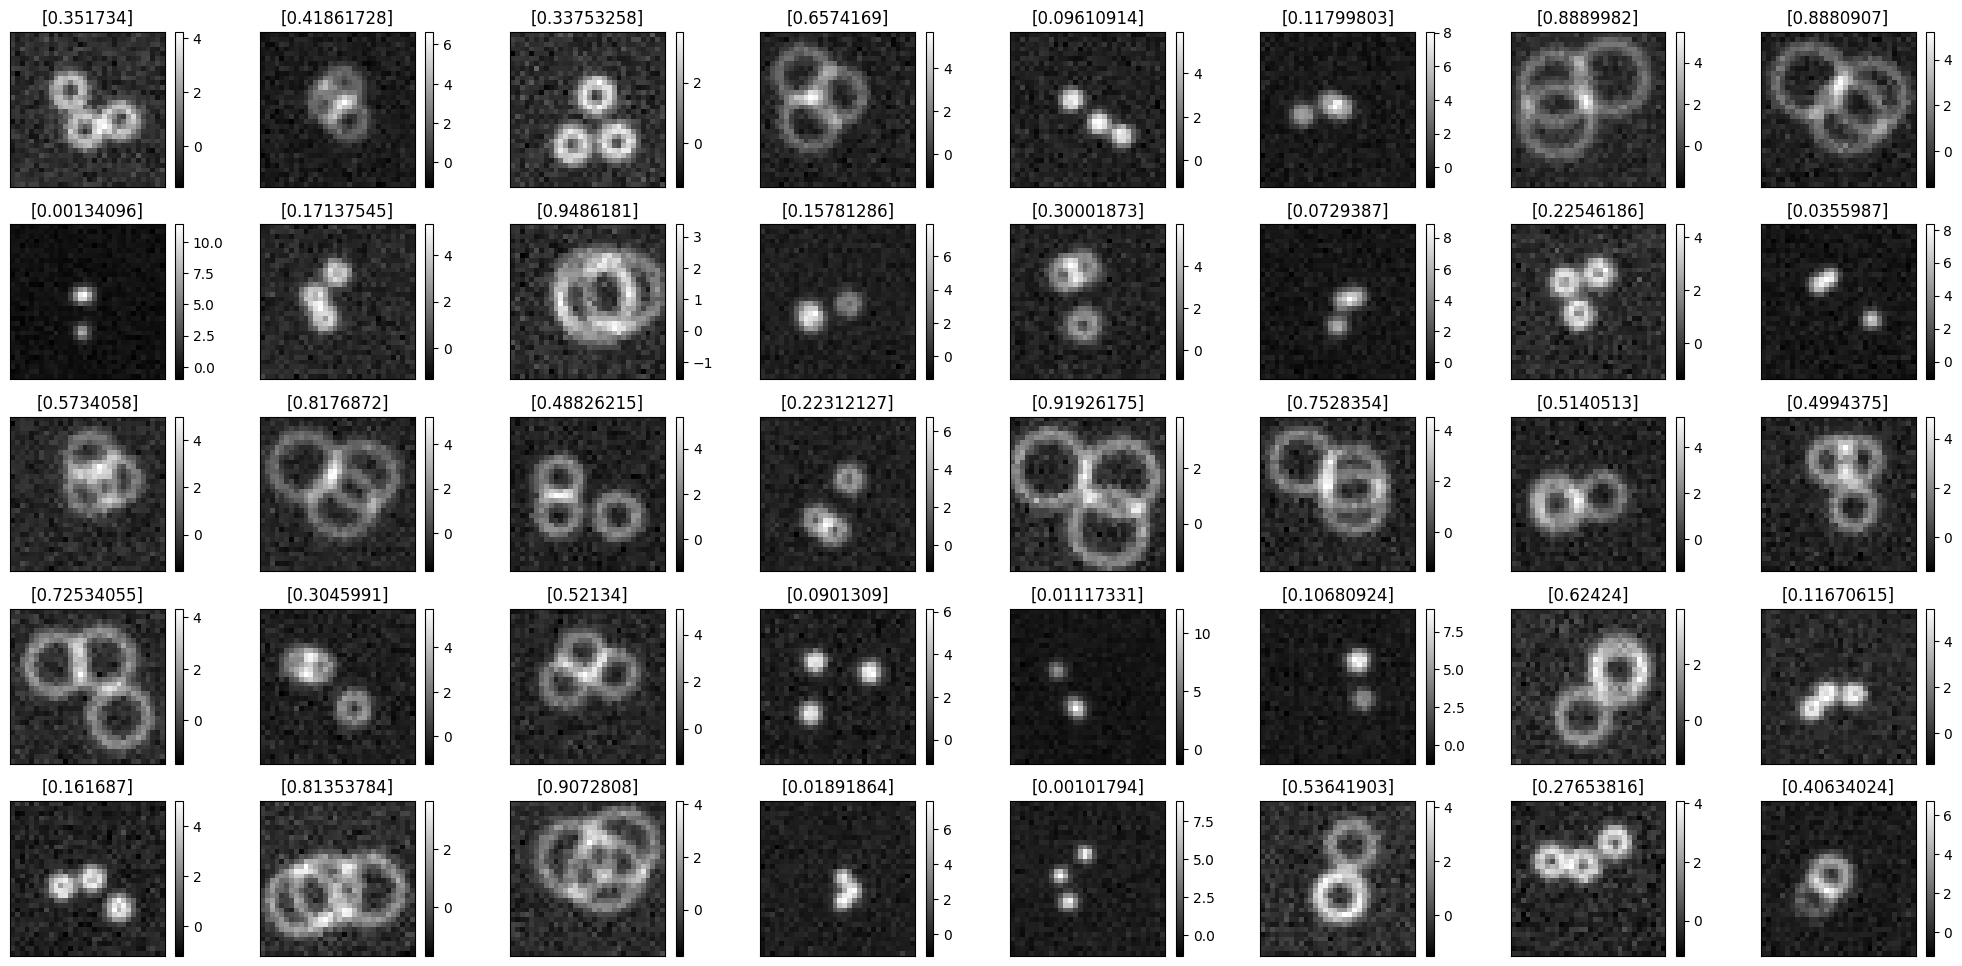

In [6]:
fig = plt.figure(figsize=(20, 10))
for i in range(40):
  plt.subplot(5,8,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("{}".format(example_targets[i].numpy()))
  plt.xticks([])
  plt.yticks([])
  plt.colorbar()

We first start with a regression-based implementation, where we will train a neural network to predict the radius as a single number directly.

1. Regression model. Create a similar CNN to the one used on the MNIST dataset in the last homework. This time it should predict a single real-valued number that represents the radius. (2pt)

HINTS:
 -  If you did not finish the previous exercise scroll down to see another implementation of a CNN.
 - Always remember to count the in- and ouput dimensions of every layer in your CNN. Both `nn.Conv2d`and `nn.functional.max_pool2d`generally change the output dimensions.

In [7]:
# Useful imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## your code here
class RingRegModel(nn.Module):
    def __init__(self):
        super(RingRegModel,self).__init__()
        self.conv1= nn.Conv2d(1,32, kernel_size=5, padding=2,stride=1)  #(64-5+2*2)/1+1=64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3= nn.Conv2d(64,64, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2,2)
        # Flattens the tensor from a 4D shape (batch_size, channels, height, width) to a 2D shape (batch_size, flattened_size) where flattened_size is 64 * 4 * 4.
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Relu activation
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)  # flatten to batch_size, (fc_layer_size=64*4*4)
        x = F.relu(self.fc1(x))  # fully connected
        x = self.fc2(x)
        return x




2. Before, we were doing classification and so we used the appropriate cross-entropy loss. Now, we must replace the loss with mean square error (MSE) for regression. Define the training loop below with this new loss function. (1pt)

In [8]:
## your code here

# some global variables
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = RingRegModel().to(DEVICE)  # We move the network to the GPU

criterion = nn.MSELoss()

learning_rate = 0.001
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

def train(epoch):
    # Training loop
    network.train()  # Set the model to training mode》
    running_loss = 0.0  # for inspecting the training

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)

        optimizer.zero_grad()  # Zero the gradients
        output = network(data)  # Forward pass
        loss = criterion(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters

        running_loss += loss.item()

        if (batch_idx+1) % 100 == 0:  # Print every 100 batches
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {running_loss / 100:.4f}")
            running_loss = 0.0

3. Train the network on GPU. If everything works, you should see that the loss decreases. (Refer to previous exercises if you need guidance.) (2pt)

Hint: If your network doesn't train, try using a smaller learning rate (e.g. 0.001).

In [9]:
## your code here

num_epochs = 10
for epoch in range(num_epochs):
    train(epoch)

Epoch 1, Batch 100, Loss: 0.0329
Epoch 1, Batch 200, Loss: 0.0038
Epoch 1, Batch 300, Loss: 0.0026
Epoch 1, Batch 400, Loss: 0.0019
Epoch 1, Batch 500, Loss: 0.0015
Epoch 1, Batch 600, Loss: 0.0013
Epoch 1, Batch 700, Loss: 0.0010
Epoch 2, Batch 100, Loss: 0.0009
Epoch 2, Batch 200, Loss: 0.0009
Epoch 2, Batch 300, Loss: 0.0009
Epoch 2, Batch 400, Loss: 0.0006
Epoch 2, Batch 500, Loss: 0.0008
Epoch 2, Batch 600, Loss: 0.0009
Epoch 2, Batch 700, Loss: 0.0007
Epoch 3, Batch 100, Loss: 0.0006
Epoch 3, Batch 200, Loss: 0.0005
Epoch 3, Batch 300, Loss: 0.0007
Epoch 3, Batch 400, Loss: 0.0007
Epoch 3, Batch 500, Loss: 0.0006
Epoch 3, Batch 600, Loss: 0.0005
Epoch 3, Batch 700, Loss: 0.0004
Epoch 4, Batch 100, Loss: 0.0004
Epoch 4, Batch 200, Loss: 0.0005
Epoch 4, Batch 300, Loss: 0.0005
Epoch 4, Batch 400, Loss: 0.0004
Epoch 4, Batch 500, Loss: 0.0007
Epoch 4, Batch 600, Loss: 0.0004
Epoch 4, Batch 700, Loss: 0.0004
Epoch 5, Batch 100, Loss: 0.0003
Epoch 5, Batch 200, Loss: 0.0003
Epoch 5, B

4. Illustrate the reconstruction quality by running 1000 test images through the network and recording the outputs.  Show correct (x-axis) vs reconstructed (y-axis) radii in a scatter plot (`plt.scatter`). How well does your network perform? (1pt)


Test set: Avg. loss: 0.0003



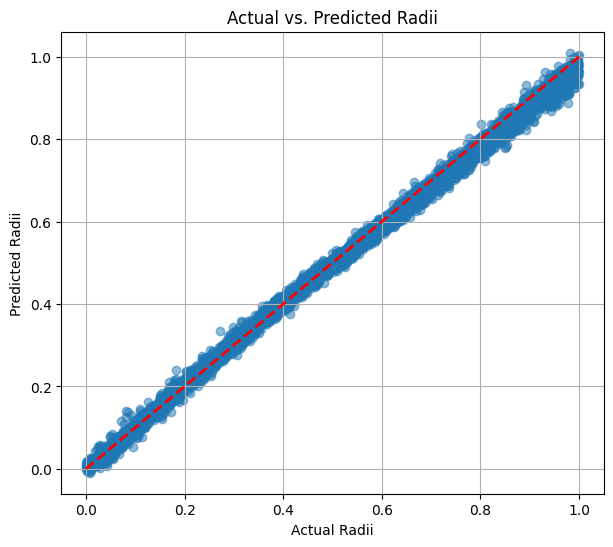

In [10]:
## your code here

import matplotlib.pyplot as plt

def evaluate_model(test_loader, network, device):
    network.eval()  # Set the model to evaluation mode
    actual_radii = []
    predicted_radii = []
    test_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)

            actual_radii.extend(target.cpu().numpy().flatten())
            predicted_radii.extend(output.cpu().numpy().flatten())

            test_loss += criterion(output, target).item() * data.size(0)  # Accumulate the loss, multiply by batch size

    test_loss /= len(test_loader.dataset)  # Compute the average test loss
    print(f'\nTest set: Avg. loss: {test_loss:.4f}\n')  # Print the average test loss

    return actual_radii, predicted_radii

# Assuming test_loader is already defined
actual_radii, predicted_radii = evaluate_model(test_loader, network, DEVICE)

# Scatter plot of actual vs. predicted radii
plt.figure(figsize=(7, 6))
plt.scatter(actual_radii, predicted_radii, alpha=0.5)
plt.xlabel('Actual Radii')
plt.ylabel('Predicted Radii')
plt.title('Actual vs. Predicted Radii')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2)  # Diagonal line for reference
plt.grid(True)
plt.show()


YOUR ANSWER HERE

The average loss (function value) is $4×10^{-4}$, and the linear relationship shown above indicates that for any actual radius, the predicted radius is very close to the true value.

5. Imagine your are provided with a single image, and you have to use your network to estimate the radius of the rings and quote your best estimate together with error bars. Write 2-3 qualitative sentences about how you could obtain this error bar from the plot that you generated in the previous point. (1pt)

YOUR ANSWER HERE

The predicted radii of these images serve as the best estimate, and their errors from the true value are the error. The standard deviation of the training set minus the true value can be used as the confidence interval for 1$σ$. The combination of the two allows us to determine if the error bars are exceeded.

**Usage** of AI: *COMMENT HERE*

GPT define the model class and the train function. However, it misunderstood the relation between paddling, stride and how they work in torch. So I have to look up to document files to modify them. The rest are basically copied from my previous work.

### 2. Simulation-based inference of posteriors (11 pt)

In the previous exercise, we predicted a single value for the radius, but this did not tell us anything about the probability of the predicted value. In this exercise, we will use the neural likelihood-free based inference method (focusing on neural ratio estimation) discussed in class to obtain proper Bayesian posteriors for the radius, instead of just a point estimator.

Let's start by defining a neural network that takes as input both an image $x$ as well as a label (in our case radius) $z$.  The output will be the probability that $x$ and $z$ are jointly drawn, $x, z \sim p(x, z)$, rather than marginally, $x, z \sim p(x)p(z)$.

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(501, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x, z):  # that's how we split the image with a label.
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 500)  #
        x = torch.cat((x, z), axis = 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

1. What does the `torch.cat` function do in this context? Relate it back to the math dicussed in class.  (1 pt)


YOUR ANSWER HERE


`torch.cat` is used to combine the processed image tensor `x` with the label tensor (radius) `z` along `axis=2` before feeding them into the fully connected layers. This allows the network to consider both the image features and the label when computing the joint probability $p(x,z)$

Now we define the optimizer, and instantiate the network.

In [12]:
learning_rate = 0.001
DEVICE = 'cuda'
network = Net().to(DEVICE)  # We move the network to the GPU
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

By default, we will use `n_epochs = 3` throughout.  Leave it like that.

In [ ]:
n_epochs = 3  # 3 epochs by default.

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

The main training loop is now given as follows.

In [ ]:
log_interval = 10

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = data.to(DEVICE)
    target = target.to(DEVICE)

    output_joined = network(data[1:], target[1:])
    output_marginal = network(data[1:], torch.rand_like(target[1:]))

    loss = -torch.log(output_joined) - torch.log(1-output_marginal)
    loss = loss.sum()

    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

2. Explain the role of the two different `output` variables, and how those enter the binary cross-entropy loss function. Write down the mathematical definition of the loss function that we implement (in terms of an integral). (1 pt)

YOUR ANSWER HERE

`output_joined`, defined as $\displaystyle f( x,z) \ where\ x,z\sim p( x,z) \ and\ f$ being the neral network is the output given that $\displaystyle x,z$ are drawn from a joined probability, while `output_marginal`, defined as $\displaystyle f( x,z')$ is that given that $\displaystyle x,z$ are drawn seperately from reference distribution $\displaystyle x,z\sim p( x) p( z)$.



The binary cross-entropy is
\begin{equation*}
\mathcal{L} =-\mathbb{E}_{p(x,z)} [\log (f(x,z))]-\mathbb{E}_{p(x)p(z)}\left[\log\left( 1-f\left( x,z^{\prime }\right)\right)\right]
\end{equation*}
where $\displaystyle \mathbb{E}$ represents the mean distribution from the 2 output. The loss function decrease when sampling from the joined distribution, and vice versa for a marginal one.

In [ ]:
for epoch in range(1, n_epochs + 1):
  train(epoch)

3. Write some code to plot, for a given image, the posterior of the radius. To this end, the network should be evaluated for the same $x$ and for a continuous range of $z$'s (i.e. radii).  Plot the posterior for 10 different images, together with the true values as a vertical line (`plt.axvline`). Hint: check how the data were generated to remind yourself of the allowed radii in our synthetic dataset. Make sure to correctly normalize the posterior to one (neural ratio estimation provides posteriors that are only approximately normalized to one). (3 pt)

In [ ]:
## your code here

# Define the range of radii to evaluate
radii_range = np.linspace(0, 1, 100)  # 100 radii values between 0 and 1

def plot_posterior(image, true_radius, network, device, radii_range):
    network.eval()
    posteriors = []

    # Convert the radii range to a tensor
    radii_tensor = torch.tensor(radii_range, dtype=torch.float32).view(-1, 1).to(device)
    image = image.to(device).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        for radius in radii_tensor:
            output = network(image, radius.unsqueeze(0))
            posteriors.append(output.item())

    # Normalize the posterior to sum to 1
    posteriors = np.array(posteriors)
    posteriors /= posteriors.sum()

    # Plot the posterior
    plt.plot(radii_range, posteriors, label='Posterior')
    plt.axvline(x=true_radius, color='red', linestyle='--', label='True Radius')
    plt.xlabel('Radius')
    plt.ylabel('Posterior Probability')
    plt.title('Posterior Distribution of Radius')
    plt.legend()
    plt.grid(True)
    plt.show()

# Select 10 different images and their true radii from the test set
images, true_radii = next(iter(test_loader))
images = images[:10]
true_radii = true_radii[:10]

# Plot the posterior for each selected image
for i in range(10):
    plot_posterior(images[i], true_radii[i].item(), network, DEVICE, radii_range)


4. For each image in the test dataset, derive a posterior and then the boundaries of the 68% credible interval (highest posterior density interval). Next, since our test dataset contains 1000 examples, calculate the fraction of the test examples where the true value lies within the 68% containment interval of the posterior predicted by the neural network. Report this value. Lastly, visualize this by plotting, for each example in the test dataset, a black vertical line representing the containment interval on a plot where the x_axis indicates the true values of the radius and the y-axis represens the NN-predicted values. (3pts)

Hint: your plot should look something like this in the end:

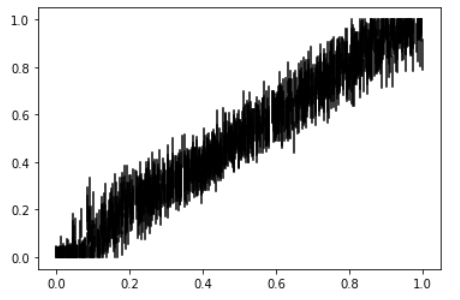

In [ ]:
## your code here

def compute_posterior(image, network, device, radii_range):
    network.eval()
    image = image.to(device).unsqueeze(0)  # Add batch dimension
    radii_tensor = torch.tensor(radii_range, dtype=torch.float32).view(-1, 1).to(device)  # Convert the radii range to a tensor

    with torch.no_grad():
        repeated_image = image.repeat(radii_tensor.size(0), 1, 1, 1)  # Repeat the image tensor for each radius
        output = network(repeated_image, radii_tensor)  # Perform a single forward pass for all radii
        posteriors = output.cpu().numpy().flatten()  # Convert output to numpy array

    posteriors /= posteriors.sum()  # Normalize the posterior to sum to 1
    return radii_range, posteriors

def highest_posterior_density_interval(radii, posteriors, credible_mass=0.68):
    sorted_indices = np.argsort(posteriors)[::-1]
    sorted_radii = radii[sorted_indices]
    sorted_posteriors = posteriors[sorted_indices]

    cumulative_density = np.cumsum(sorted_posteriors)
    interval_idx = np.where(cumulative_density >= credible_mass)[0][0]

    hpdi = sorted_radii[:interval_idx + 1]
    lower_bound = hpdi.min()
    upper_bound = hpdi.max()

    return lower_bound, upper_bound

def evaluate_posterior(loader, network, device, radii_range, credible_mass=0.68):
    in_interval_count = 0
    credible_intervals = []
    true_radii_list = []
    predicted_radii_list = []

    for data, target in loader:
        data, target = data.to(device), target.to(device)

        for i in range(data.size(0)):
            radii, posteriors = compute_posterior(data[i], network, device, radii_range)
            lower_bound, upper_bound = highest_posterior_density_interval(radii, posteriors, credible_mass=credible_mass)

            credible_intervals.append((lower_bound, upper_bound))
            true_radii_list.append(target[i].item())
            predicted_radii_list.append(radii[np.argmax(posteriors)])

            if lower_bound <= target[i].item() <= upper_bound:
                in_interval_count += 1

    fraction_in_interval = in_interval_count / len(loader.dataset)

    return credible_intervals, true_radii_list, predicted_radii_list, fraction_in_interval




In [ ]:
# Visualization for 68% credible interval
credible_intervals, true_radii_list, predicted_radii_list, _ = evaluate_posterior(test_loader, network, DEVICE, radii_range, credible_mass=0.68)

plt.figure(figsize=(10, 6))
for i in range(len(true_radii_list)):
    plt.plot([true_radii_list[i], true_radii_list[i]], credible_intervals[i], color='black')
plt.scatter(true_radii_list, predicted_radii_list, alpha=0.5)
plt.xlabel('True Radii')
plt.ylabel('NN-Predicted Radii')
plt.title('True Radii vs. NN-Predicted Radii with 68% Credible Intervals')
plt.grid(True)
plt.show()


5. Repeat part of the previous exercise for 95% and 99% credible intervals and estimate the fraction of training data examples where the true value is contained in the credible interval (no visualization like in the previous exercise required).  Discuss whether your posterior estimation is conservative or overconfident (3 pt).


In [ ]:
## your code here
# Define the credible masses for 68%, 95%, and 99% intervals
credible_masses = [0.68, 0.95, 0.99]

# Evaluate the posterior intervals for the training set
fractions_train = {mass: evaluate_posterior(train_loader, network, DEVICE, radii_range, credible_mass=mass)[-1] for mass in credible_masses}

print(f"Fraction of training examples within 68% credible interval: {fractions_train[0.68]:.4f}")
print(f"Fraction of training examples within 95% credible interval: {fractions_train[0.95]:.4f}")
print(f"Fraction of training examples within 99% credible interval: {fractions_train[0.99]:.4f}")


YOUR ANSWER HERE

I used up all GPU time on Colab, but I guess it's conservative based on previous results.

**Usage** of AI: *COMMENT HERE*

GPT helped me with plotting the posterior and did part 4.

### 3. Loss function gymnastics (4 pt)

1. (2 points) The loss function for neural ratio estimation is given by
$$
L=-\mathbb{E}_{x, z \sim p(x, z)}\left[\ln \sigma\left(f_\theta(x, z)\right)\right]-\mathbb{E}_{x, z \sim p(x) p(z)}\left[\ln \sigma\left(-f_\theta(x, z)\right)\right] .
$$

We claimed in the lecture that minimizing the loss will lead to a $f_\theta(x, z) \approx \ln r(x, z)$, with the likelihood-to-evidence ratio $r(x, z) \equiv \frac{p(x, z)}{p(x) p(z)}$. Show that minimizing the loss w.r.t. $\theta$ indeed yields $\ln r(x, z)$. Explain all steps of your calculation.

YOUR ANSWER HERE

 \begin{array}{l}
L[ f_{\phi } (\mathbf{x} ,z)] =-\int dxdz[ p(\mathbf{x} ,z)\ln( \sigma ( f_{\phi } (\mathbf{x} ,z))) +p(\mathbf{x} )p(z)\ln( \sigma ( -f_{\phi } (\mathbf{x} ,z)))]\\
\begin{aligned}
\frac{\partial }{\partial \phi } L[ f_{\phi } (\mathbf{x} ,z)] & =-\frac{\partial }{\partial \phi }\int dxdz[ p(\mathbf{x} ,z)\ln( \sigma ( f_{\phi } (\mathbf{x} ,z))) +p(\mathbf{x} )p(z)\ln( \sigma ( -f_{\phi } (\mathbf{x} ,z)))]\\
 & =-\int dxdz[ p(\mathbf{x} ,z)( 1-\sigma ( f_{\phi } (\mathbf{x} ,z))) -p(\mathbf{x} )p(z)( 1-\sigma ( -f_{\phi } (\mathbf{x} ,z) ))]\frac{\partial f_{\phi } (\mathbf{x} ,z)}{\partial \phi }\\
 & =0
\end{aligned}\\
\therefore \frac{p( x,z)}{p( x) p( z)} =\frac{1-\sigma ( -f_{\phi } (\mathbf{x} ,z))}{1-\sigma ( f_{\phi } (\mathbf{x} ,z))} =\frac{1-\frac{1}{1+exp( f_{\phi })}}{1-\frac{1}{1+exp( -f_{\phi })}} =\frac{1+e^{f}}{1+e^{-f}} =e^{f_{\phi }}\\
\therefore f_{\phi } =ln\left(\frac{p( x,z)}{p( x) p( z)}\right) =ln( r( x,z)\\
\end{array}

2. (2 points) After warming up with the NRE loss, now consider the bivariate probability distribution $p(x, y)$ and the loss function
$$
L\left[M_\phi\right]=\int d x d y p(x, y)\left(x-M_\phi(y)\right)^2,
$$
where $M_\phi(y)$ denotes a flexible neural network with 1-dim input and 1-dim output, parametrized through the parameters $\phi$.

Minimize the loss w.r.t. $\phi$ and derive the $M_\phi(y)$  that minimizes $L$.

YOUR ANSWER HERE

 \begin{array}{l}
L[ M_{\phi }] =\int dxdyp(x,y)( x-M_{\phi } (y))^{2}\\
\begin{aligned}
\frac{\partial }{\partial \phi } L[ f_{\phi } (\mathbf{x} ,z)] & =-\frac{\partial }{\partial \phi }\int dxdyp(x,y)( x-M_{\phi } (y))^{2}\\
 & =-\int dxdz\left[ p( x,z) \cdotp 2( x-M_{\phi } (y))\frac{\partial M_{\phi }( y)}{\partial \phi }\right]\\
 & =0
\end{aligned}\\
\therefore x=M_{\phi } (y)
\end{array}
gives the lowest loss.

**Usage** of AI: *COMMENT HERE*